In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import Binarizer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer


In [2]:
df = pd.read_csv('dataset/mobile_addiction_data_processed.csv')


0       1
1       1
2       1
3       1
4       1
       ..
2981    1
2982    1
2983    1
2984    1
2985    1
Name: Anomali, Length: 2986, dtype: int64


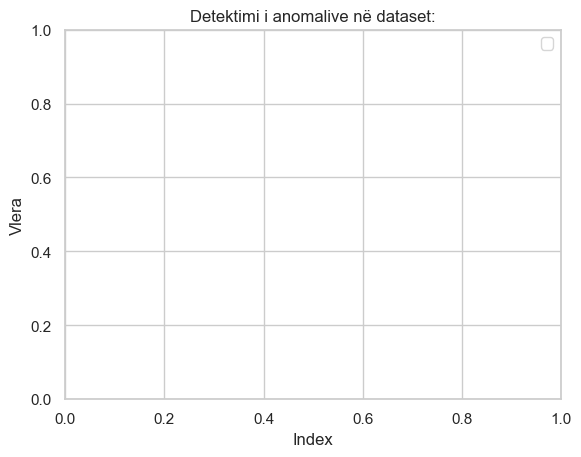

In [ ]:
# Zgjidhen vetëm kolonat numerike nga dataseti
from sklearn.ensemble import IsolationForest


numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
numeric_data = df[numeric_columns]

# Inicializimi i Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
df['Anomali'] = iso_forest.fit_predict(numeric_data)
print(df['Anomali'])
# Ndarja e anomalive dhe i të dhënave normale për vizualizim
normal_data = df[df['Anomali'] == 1]
anomalies = df[df['Anomali'] == -1]

sns.set_theme(style='whitegrid')

# # Vizualizimi i Pair Plot
# plt.figure(figsize=(12, 8))
# sns.pairplot(df, hue='Anomali', palette={1: 'blue', -1: 'red'}, diag_kind='kde', markers=["o", "s"])
# plt.suptitle('Pair Plot per detektimin e anomalive', y=1.02)
# plt.show()

# Vizualizimi shtesë i scatter plot për secilën kolone
plt.figure(figsize=(12, 8))
for col in numeric_columns:
    plt.scatter(normal_data.index, normal_data[col], label='Normal', color='b', alpha=0.5, s=20)
    plt.scatter(anomalies.index, anomalies[col], label='Anomali', color='r', alpha=0.5, s=20)

plt.legend(['Normal', 'Anomali'])
plt.title('Detektimi i anomalive në dataset:')
plt.xlabel('Index')
plt.ylabel('Vlera')
plt.show()

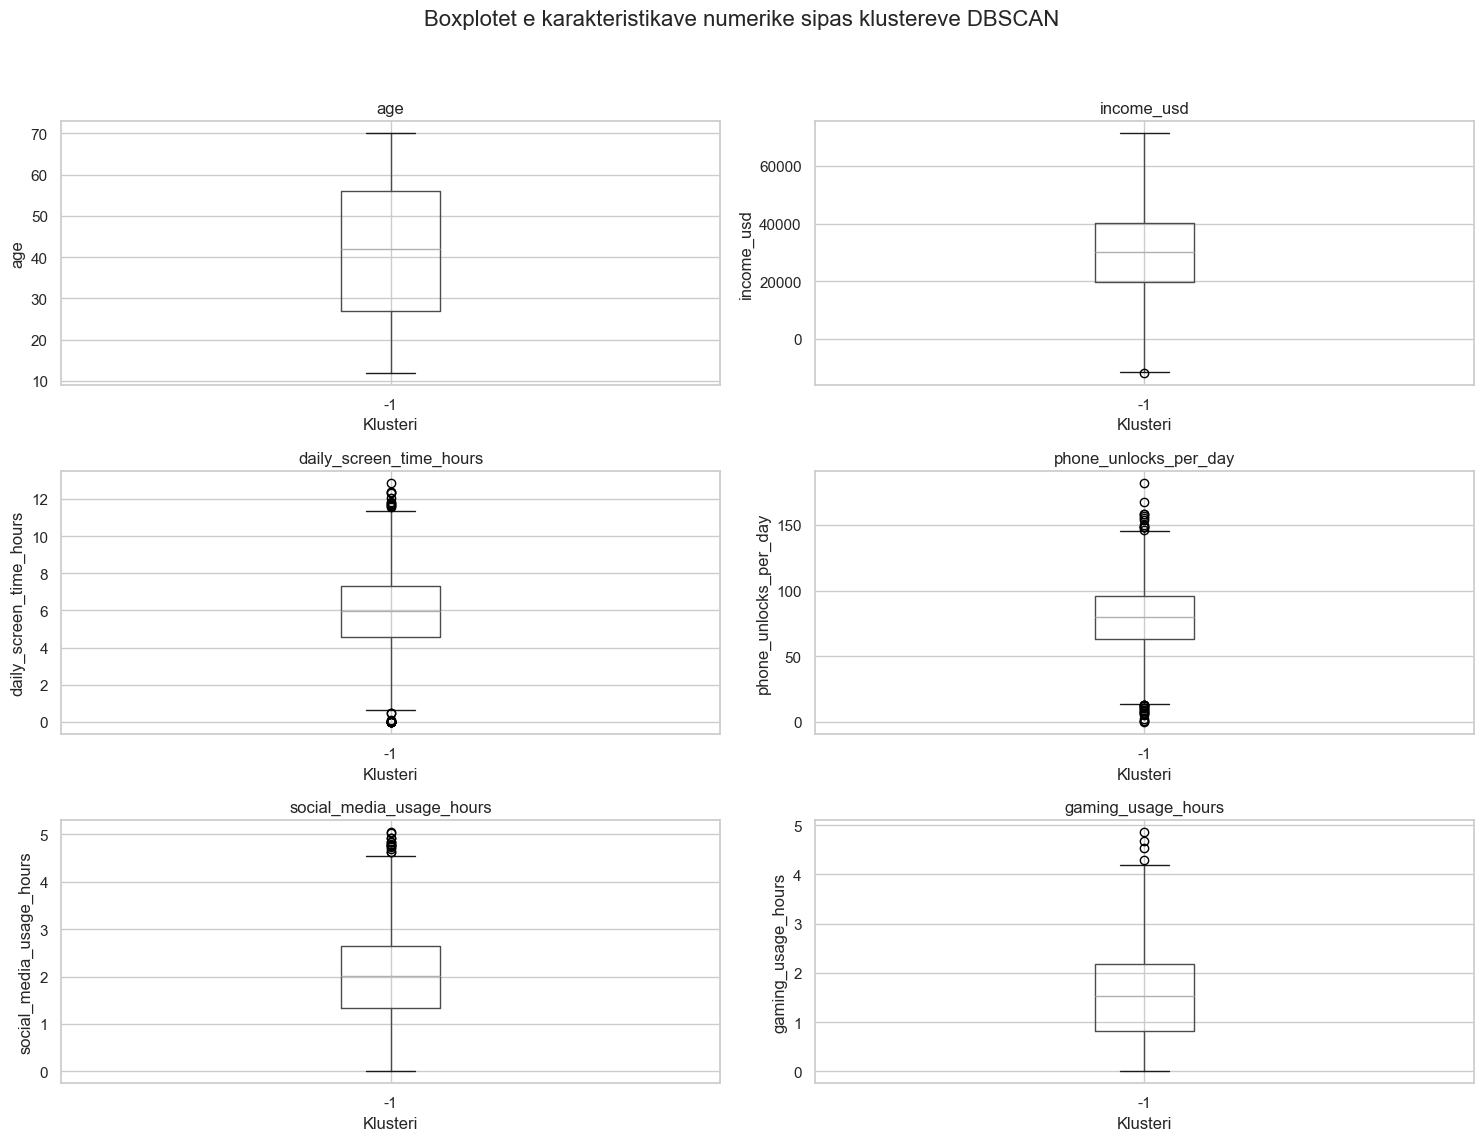

In [4]:
from sklearn.cluster import DBSCAN

numerical_columns = [
    'age',
    'income_usd',
    'daily_screen_time_hours',
    'phone_unlocks_per_day',
    'social_media_usage_hours',
    'gaming_usage_hours',
    'streaming_usage_hours',
    'messaging_usage_hours',
    'work_related_usage_hours',
    'sleep_hours',
    'physical_activity_hours',
    'mental_health_score',
    'depression_score',
    'anxiety_score',
    'stress_level',
    'time_spent_with_family_hours',
    'online_shopping_hours',
    'monthly_data_usage_gb',
    'age_first_phone',
    'push_notifications_per_day',
    'tech_savviness_score',
    'relationship_status_encoded',
    'urban_or_rural_encoded',
    'self_reported_addiction_level_encoded',
    'gender_encoded',
    'Total_Entertainment_Hours',
    'Overall_Mental_Health_Index'
]


data_numerical = df[numerical_columns]

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_numerical)

dbscan = DBSCAN(eps=0.5, min_samples=5)

clusters = dbscan.fit_predict(data_scaled)

df['Cluster'] = clusters

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))

for ax, column in zip(axes.flatten(), numerical_columns):
    df.boxplot(column=column, by='Cluster', ax=ax)
    ax.get_figure().suptitle('Boxplotet e karakteristikave numerike sipas klustereve DBSCAN', fontsize=16)
    ax.set_title(column)
    ax.set_xlabel('Klusteri')
    ax.set_ylabel(column)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

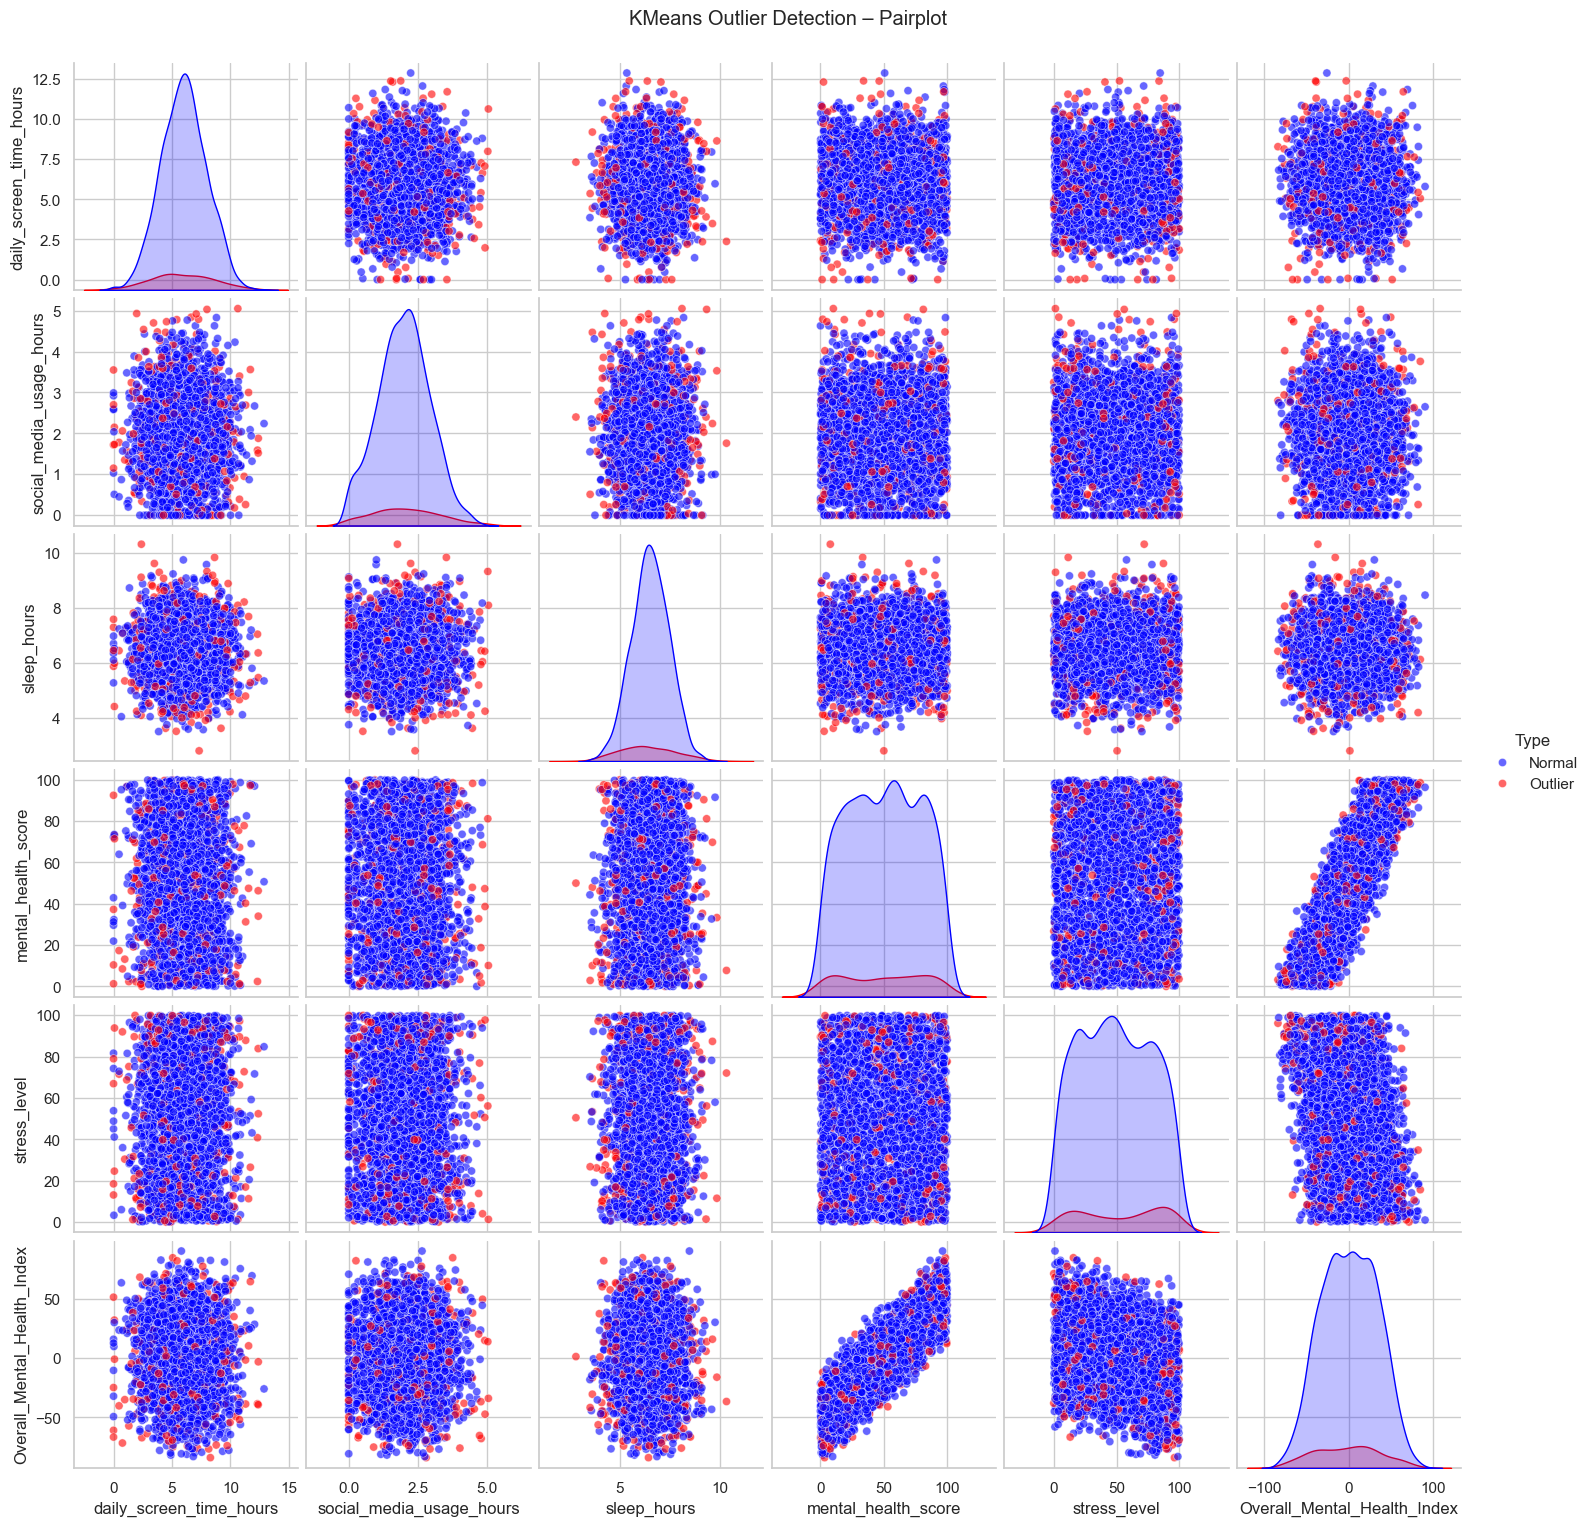

In [5]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

features = df[numerical_columns]

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(scaled_features)

distances = kmeans.transform(scaled_features)
min_distance = np.min(distances, axis=1)

threshold = np.percentile(min_distance, 90)
df['Outlier'] = min_distance > threshold

df['Type'] = df['Outlier'].apply(lambda x: 'Outlier' if x else 'Normal')

plot_columns = [
    'daily_screen_time_hours',
    'social_media_usage_hours',
    'sleep_hours',
    'mental_health_score',
    'stress_level',
    'Overall_Mental_Health_Index'
]

pairplot = sns.pairplot(
    df,
    vars=plot_columns,
    hue='Type',
    palette={'Normal': 'blue', 'Outlier': 'red'},
    plot_kws={'alpha': 0.6, 's': 35},
    diag_kind='kde',
    diag_kws={'fill': True}
)

pairplot.fig.suptitle('KMeans Outlier Detection – Pairplot', y=1.02)
plt.show()


Total rows: 2986
Outliers detected: 85
Rows after removal: 2901


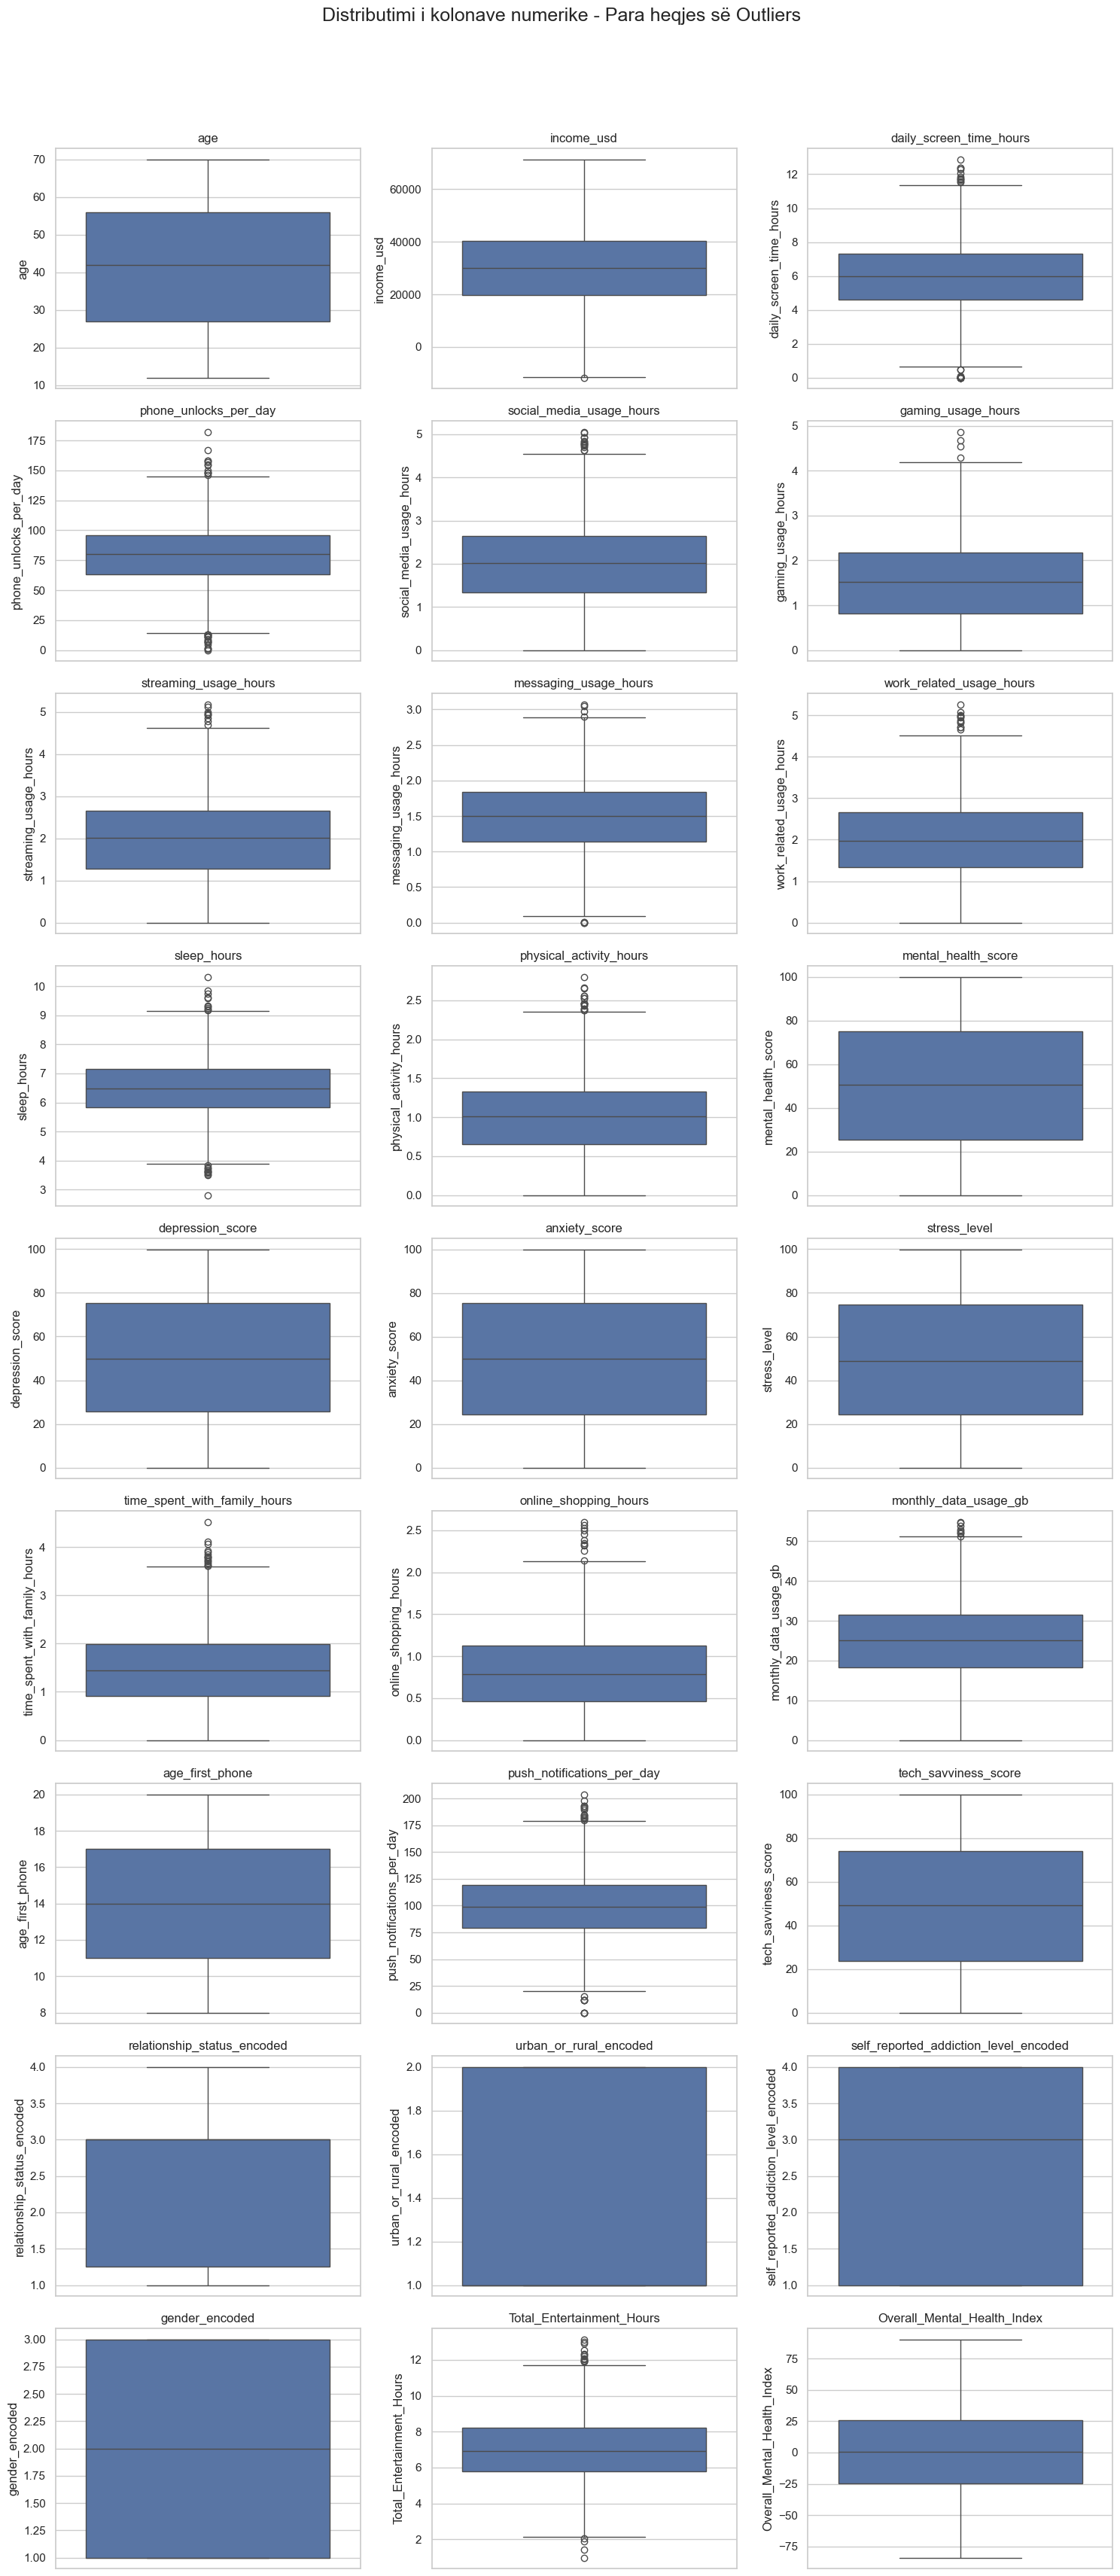

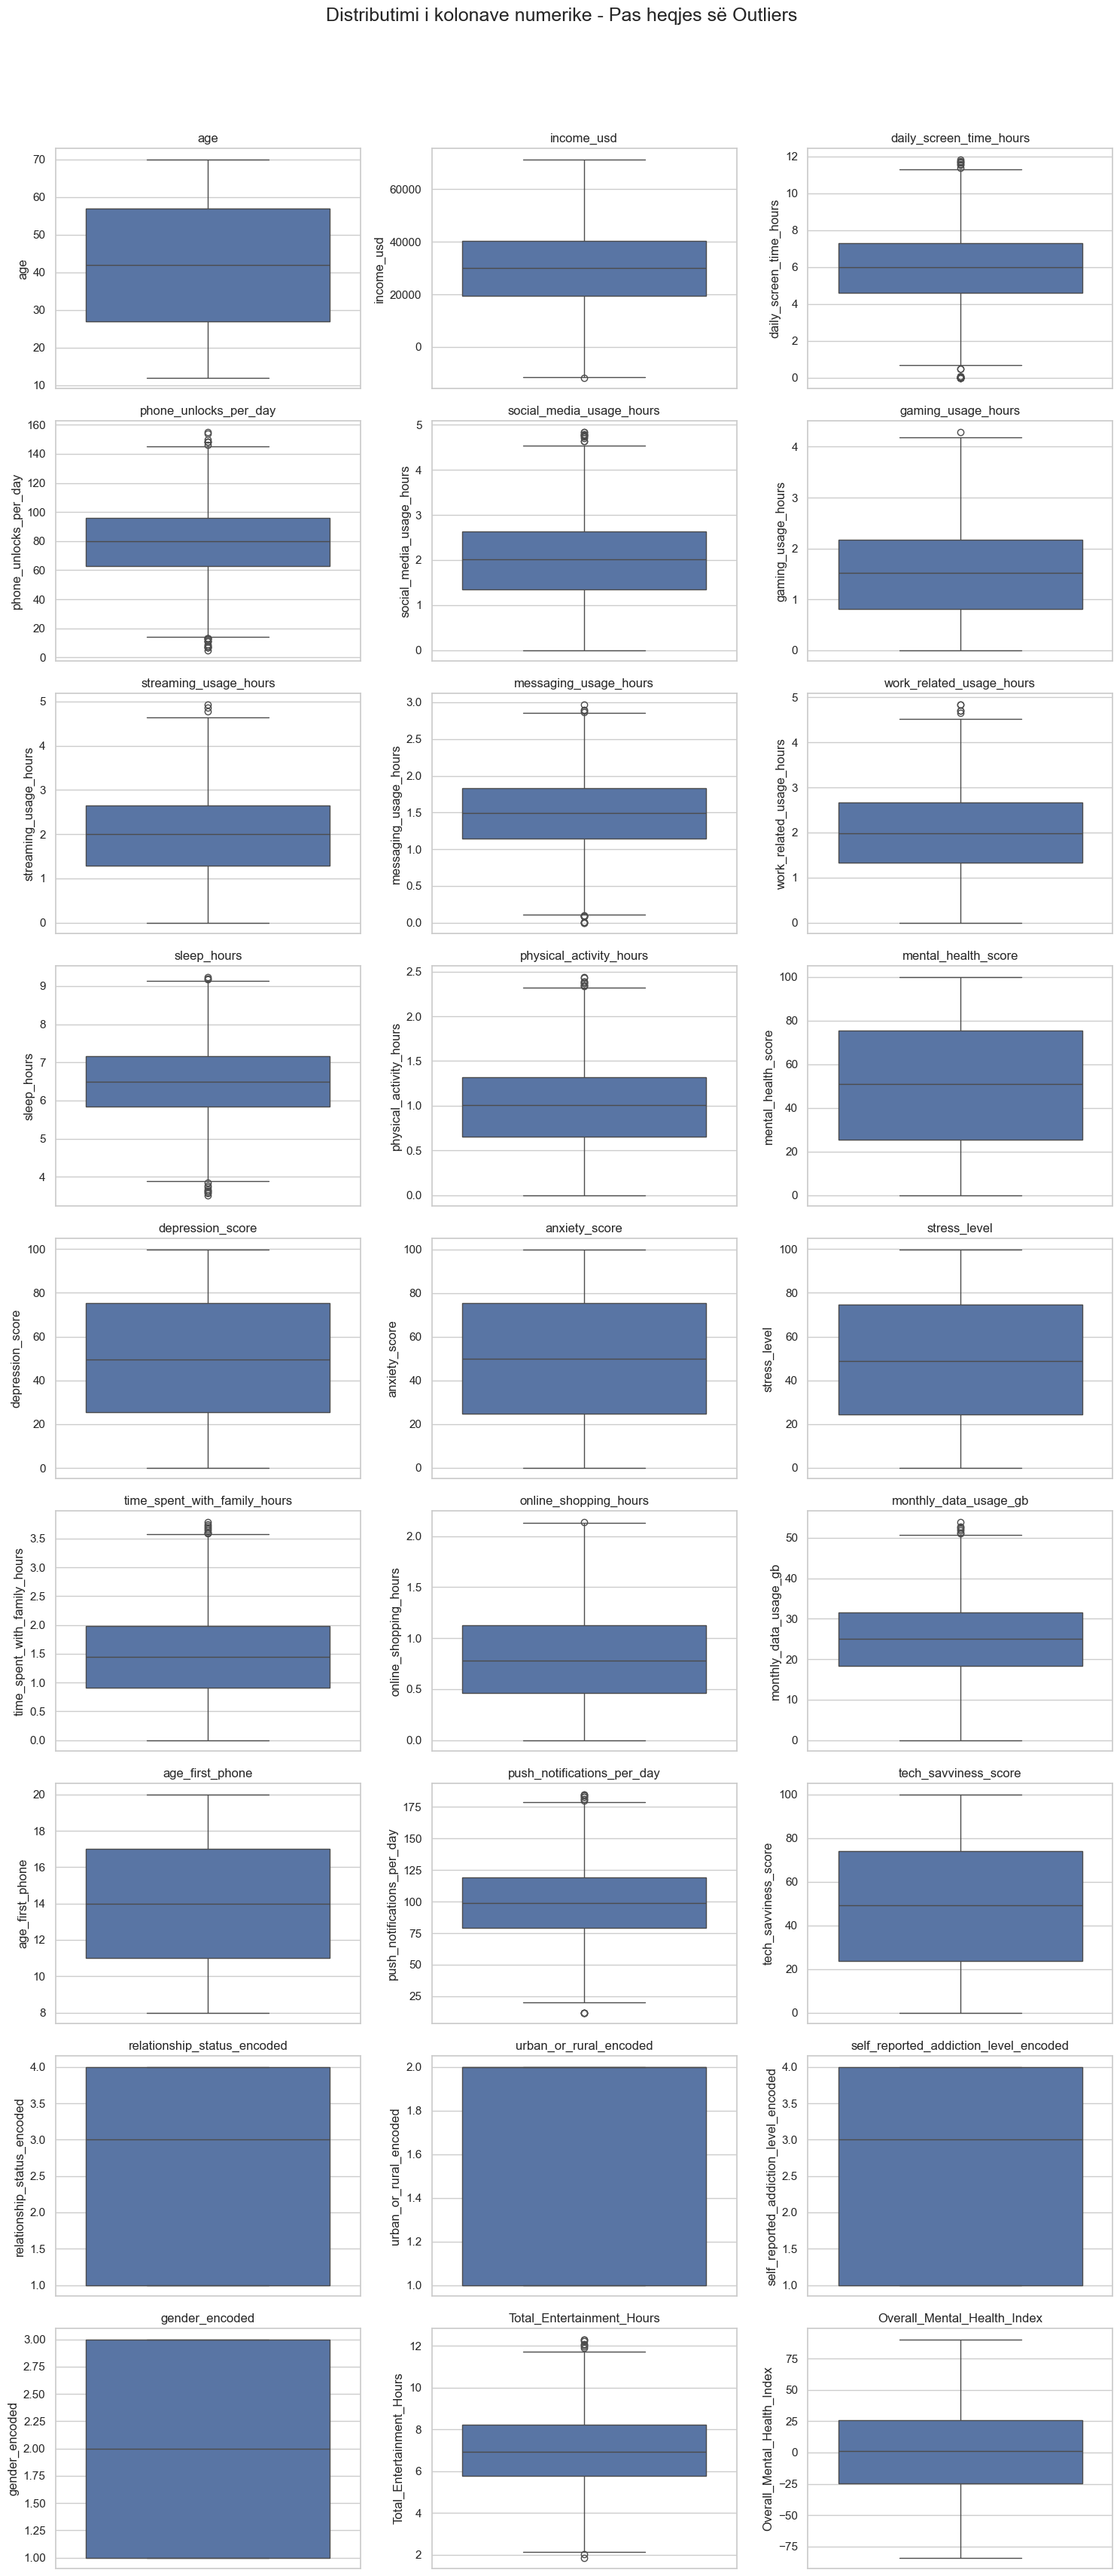

In [6]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns


data_numeric = df[numerical_columns]

z_scores = np.abs(stats.zscore(data_numeric, nan_policy='omit'))

threshold = 3

outliers_mask = (z_scores > threshold).any(axis=1)

print("Total rows:", len(df))
print("Outliers detected:", outliers_mask.sum())
print("Rows after removal:", len(df) - outliers_mask.sum())

df_clean = df[~outliers_mask].reset_index(drop=True)

sns.set_theme(style="whitegrid")

def plot_boxplots(data, title):
    n_cols = 3
    n_rows = int(np.ceil(len(numerical_columns) / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows*4))
    axes = axes.flatten()
    
    for i, col in enumerate(numerical_columns):
        sns.boxplot(y=data[col], ax=axes[i])
        axes[i].set_title(col)
    
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.suptitle(title, fontsize=18)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

plot_boxplots(df, "Distributimi i kolonave numerike - Para heqjes së Outliers")

plot_boxplots(df_clean, "Distributimi i kolonave numerike - Pas heqjes së Outliers")

df_outliers = df[outliers_mask]
